In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
from scipy.interpolate import Rbf, bisplev, RectBivariateSpline
from mpl_toolkits.mplot3d import Axes3D

In [2]:
# ODE parameters

d = 2
A = np.array([
    [1.0, 0.0],
    [1.0, 1.0]
])

def s_func(x=None, t=None):
    '''
    Coefficient matrix for random part of ODE
    '''
    
    return np.eye(d, d)

def f_func(x=None, t=None):
    '''
    Rhs for ODE dx / dt = f(x, t)
    '''
    
    return -A@x

def fx_func(x=None, t=None):
    '''
    Partial (x-) derivative of rhs for ODE dx / dt = f(x, t)
    '''
    
    return -A

In [3]:
# Time discretization parameters

t_min = -3.0
t_max = 3.0
t_poi = 64
t_list = np.linspace(t_min, t_max, t_poi)
h = (t_max - t_min) / (t_poi - 1)

In [4]:
# Solver options

nsteps = 2
nsamples = 500

In [5]:
def logrho0(x):
    '''
    Log likelihood for normal distribution
    '''
    
    # res = np.diag(x.T@x)
    res = np.einsum('ik,ik->k', x, x)
    
    return res

In [6]:
def sde_step_x(x, t, f, s, h):
    '''
    One step of Euler-Mayruyama scheme
    Input:
        x - current value
            (1D ndarray)
        t - current time
            (float)
        f - function f(x, t) that return rhs or its value
            (1D ndarray or function)
        s - function s(x, t) that return stochastic part or its value
            (2D ndarray or function)
        h - time step
            (float)
    Output:
          - current value
            (1D ndarray)
    '''
    
    if callable(f): f = f(x, t)
    if callable(s): s = s(x, t)
        
    e = np.random.randn(*x.shape)
    
    res = x + h * f + np.sqrt(h) * s * e

    return res

In [7]:
def sde_step_r(r, x, t, fx, s, h):
    '''
    One step for probability distribution
    r = E r_0 (1-h*Tr(df/dx))
    '''
    
    res = r * (1. - h * np.trace(fx_func(x, t)))
    
    return res

In [12]:
def compute(x0, h, nsteps, nsamples, rho_prev):
    x = np.copy(x0)
    K = x.shape[1]
    x = np.repeat(x.reshape((d, -1)), nsamples, axis=1)
    
    r = np.ones(x.shape[1])
    for _ in range(nsteps):
        print('xxx ', x)
        r = sde_step_r(r, x, t, fx, s, h)
        x = sde_step_x(x, t, f_func, noise, h)
 
    #w = np.exp(-logrho0(x))*eta
    w = rho_prev(*x, grid=False)*r
    
    w = np.reshape(w, (K, nsamples))
    res = np.mean(w, axis=1)
    return res

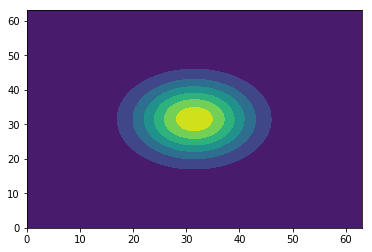

In [9]:
x, y = np.meshgrid(t_list, t_list)
w = np.array([x, y]).reshape((2, -1))
val = np.exp(-logrho0(w))

plt.contourf(val.reshape((t_poi, t_poi)))
plt.show()

In [10]:
fun = RectBivariateSpline(t_list, t_list, val.reshape((t_poi, t_poi)))
#fun = Rbf(x.flatten(), y.flatten(), val.flatten())
#fun1 = Rbf(x.flatten(), y.flatten(), res.flatten())

In [13]:
res = compute(w, h, nsteps, nsamples, fun)
res = res.reshape((t_poi, t_poi))
print(np.sum(res))

xxx  [[-3. -3. -3. ...  3.  3.  3.]
 [-3. -3. -3. ...  3.  3.  3.]]


NameError: name 't' is not defined

In [ ]:
tm = 0.0
for _ in range(2):
    res = compute_value(w, h, nsteps, nsamples, fun)
    res = res.reshape((n_poi, n_poi))
    print(np.sum(res))

    fun = RectBivariateSpline(t_list, t_list, res)

    #fun = Rbf(x.flatten(), y.flatten(), res.flatten())
    tm += h*nsteps
    #print(tm)
    #plt.contourf(x, y, res, 100)
    #plt.colorbar()